In [1]:
# import required module

import pandas as pd
import numpy as np
import os
import shutil

from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from multiprocessing import Pool
from sklearn.metrics import confusion_matrix

from PIL import Image
 
print(f"CUDA support: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"CUDA device ID: {torch.cuda.current_device()}")
print(f"CUDA device name: {torch.cuda.get_device_name(cuda_id)}")


CUDA support: True
CUDA version: 11.8
CUDA device ID: 0
CUDA device name: NVIDIA GeForce GTX 1080 Ti


In [2]:
seed = 42

torch.manual_seed(seed)
np.random.seed(seed)

# The dataset are sets of images of drivers, carrying out different actions.
### The 10 classes to predict are:
c0: normal driving \
c1: texting - right \
c2: talking on the phone - right \
c3: texting - left \
c4: talking on the phone - left \
c5: operating the radio \
c6: drinking \
c7: reaching behind \
c8: hair and makeup \
c9: talking to passenger 

The data set consists of several subjects, with each performing a series of actions that span across the 10 classes above.

In [3]:
# initial data exploration
df = pd.read_csv("src/driver_imgs_list.csv")

# check number of subjects
print(f'Unique people total: {len(df["subject"].unique())}\n{df["subject"].unique()}\n')

# check number of classes, and img counts for each class
print(f'Unique classes: {np.unique(df["classname"])}\nCounts for each: {np.unique(df["classname"], return_counts=True)[1]}\n')

# get list of subjects
people = df["subject"].unique()

Unique people total: 26
['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035'
 'p039' 'p041' 'p042' 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056'
 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']

Unique classes: ['c0' 'c1' 'c2' 'c3' 'c4' 'c5' 'c6' 'c7' 'c8' 'c9']
Counts for each: [2489 2267 2317 2346 2326 2312 2325 2002 1911 2129]



In [4]:
# split subjects into train and test (validation) groups
train_idx = np.random.choice(people, 20, replace=False)
test_idx = [x for x in people if (x in train_idx)==False]

train = df[df.subject.isin(train_idx)].copy()
test= df[df.subject.isin(test_idx)].copy()

# define class labels
y_train = train["classname"]
X_train = train.drop(columns=["classname"]).copy()

y_test = test["classname"]
X_test = test.drop(columns=["classname"]).copy()

# check shape of Feature-Label splits
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train.head(5)

(16876, 2) (16876,) (5548, 2) (5548,)


,subject,img
0,p002,img_44733.jpg
1,p002,img_72999.jpg
2,p002,img_25094.jpg
3,p002,img_69092.jpg
4,p002,img_92629.jpg


In [5]:
# make labels int
y_train = y_train.map(lambda x: int(x[1:]))
y_test = y_test.map(lambda x: int(x[1:]))

In [6]:
# check img distribution per class
##classes are similar although not exactly the same as original
print(f'Unique classes train: {np.unique(y_train)}\nCounts for each     : {np.unique(y_train, return_counts=True)[1]}\n')
print(f'Unique classes test : {np.unique(y_test)}\nCounts for each     : {np.unique(y_test, return_counts=True)[1]}\n')

Unique classes train: [0 1 2 3 4 5 6 7 8 9]
Counts for each     : [1920 1694 1749 1775 1762 1738 1761 1504 1398 1575]

Unique classes test : [0 1 2 3 4 5 6 7 8 9]
Counts for each     : [569 573 568 571 564 574 564 498 513 554]



In [7]:
# make set of test images
val_img = set(X_test["img"])

# get list of test labels
classes = list(y_test.unique())

In [11]:
# assign directory
directory_train = 'src/imgs/train/'
dest_train = 'src/train_m'

dest_train_c0 = 'src/train_m/c0'
dest_train_c1 = 'src/train_m/c1'
dest_train_c2 = 'src/train_m/c2'
dest_train_c3 = 'src/train_m/c3'
dest_train_c4 = 'src/train_m/c4'
dest_train_c5 = 'src/train_m/c5'
dest_train_c6 = 'src/train_m/c6'
dest_train_c7 = 'src/train_m/c7'
dest_train_c8 = 'src/train_m/c8'
dest_train_c9 = 'src/train_m/c9'

dest_val_c0 = 'src/val_m/c0'
dest_val_c1 = 'src/val_m/c1'
dest_val_c2 = 'src/val_m/c2'
dest_val_c3 = 'src/val_m/c3'
dest_val_c4 = 'src/val_m/c4'
dest_val_c5 = 'src/val_m/c5'
dest_val_c6 = 'src/val_m/c6'
dest_val_c7 = 'src/val_m/c7'
dest_val_c8 = 'src/val_m/c8'
dest_val_c9 = 'src/val_m/c9'

# make list of directories
train_directory = [dest_train_c0,
                   dest_train_c1,
                   dest_train_c2,
                   dest_train_c3,
                   dest_train_c4,
                   dest_train_c5,
                   dest_train_c6,
                   dest_train_c7,
                   dest_train_c8,
                   dest_train_c9]
val_directory = [dest_val_c0,
                 dest_val_c1,
                 dest_val_c2,
                 dest_val_c3,
                 dest_val_c4,
                 dest_val_c5,
                 dest_val_c6,
                 dest_val_c7,
                 dest_val_c8,
                 dest_val_c9]


# copy images from source folders
from distutils.dir_util import copy_tree
#copy_tree(directory_train, dest_train)

# function to move files
def move_file(source, destination, img_list):
    os.mkdir(destination, 0o666)
    for file in tqdm(os.listdir(source)):
        if file in img_list and file not in os.listdir(destination):
            shutil.move(os.path.join(source,file),destination)

# make directory, if it does not already exist
#os.mkdir('src/val_m', 0o666)
""" for a,b in zip(train_directory,val_directory):
    move_file(a,b, val_img) """;

In [25]:
# load resnet18:
from torchvision.models import VGG16_Weights
vgg16 = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT)

model = vgg16
#layer = model.classifier[6]

# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer of the model
num_classes = 10
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, num_classes)

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

# Define the transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_no_normalize = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
# We make another transformation without normalization just to visualize the images

# Load the train and validation datasets
train_dataset = ImageFolder('src/train_m', transform=transform)
val_dataset = ImageFolder('src/val_m', transform=transform)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)

In [26]:
import multiprocessing
# increase workers to speed up process
# defult value is 0 workers (see DataLoader documentation)
max_cores = multiprocessing.cpu_count() - 4
print(f'Using {max_cores} workers in DataLoader')

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=max_cores)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=max_cores)

Using 12 workers in DataLoader


In [27]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in tqdm(range(num_epochs)):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_dataset)
        train_acc = running_corrects.double() / len(train_dataset)
        # record training loss
        training_loss.append(train_loss)
        

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)
        # record test (validation) loss
        testing_loss.append(val_loss)

        # Print the epoch results
        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))


In [28]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device avaiable: {device}')
model.to(device)

Device avaiable: cuda


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [29]:
# initialise empty lists for tracking train and test loss
training_loss = []
testing_loss = []

In [30]:
# Fine-tune the last layer for a few epochs
optimizer = torch.optim.SGD(model.classifier[6].parameters(), lr=0.01, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# save model
torch.save(model.state_dict(), 'model/vgg16_multi_freeze_tune_v01.pt')

# load existing model
""" model.load_state_dict(torch.load('model/vgg16_multi_freeze_tune_v01.pt'))
model.eval() """

 20%|██        | 1/5 [02:43<10:54, 163.74s/it]

Epoch [1/5], train loss: 2.2540, train acc: 0.5167, val loss: 2.6991, val acc: 0.4710


 40%|████      | 2/5 [05:24<08:06, 162.11s/it]

Epoch [2/5], train loss: 1.9640, train acc: 0.6334, val loss: 2.1751, val acc: 0.5395


 60%|██████    | 3/5 [08:06<05:23, 161.87s/it]

Epoch [3/5], train loss: 1.8734, train acc: 0.6631, val loss: 3.4334, val acc: 0.4630


 80%|████████  | 4/5 [10:47<02:41, 161.57s/it]

Epoch [4/5], train loss: 1.8027, train acc: 0.6887, val loss: 2.8513, val acc: 0.5101


100%|██████████| 5/5 [13:28<00:00, 161.75s/it]

Epoch [5/5], train loss: 1.6455, train acc: 0.7086, val loss: 2.5911, val acc: 0.4859


" model.load_state_dict(torch.load('model/vgg16_multi_freeze_tune_v01.pt'))\nmodel.eval() "

In [31]:
# initialise empty lists for tracking train and test loss
training_loss = []
testing_loss = []

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
# comments out to avoid
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

# save model
torch.save(model.state_dict(), 'model/vgg16_multi_unfreeze_tune_v01.pt') 

# load existing model
""" model.load_state_dict(torch.load('model/vgg16_multi_unfreeze_tune_v01.pt'))
model.eval() """

 10%|█         | 1/10 [25:35<3:50:19, 1535.53s/it]

Epoch [1/10], train loss: 0.2540, train acc: 0.9290, val loss: 0.5994, val acc: 0.7891


 20%|██        | 2/10 [29:54<1:44:36, 784.52s/it] 

Epoch [2/10], train loss: 0.0287, train acc: 0.9911, val loss: 0.6082, val acc: 0.8315


 30%|███       | 3/10 [34:13<1:03:32, 544.69s/it]

Epoch [3/10], train loss: 0.0102, train acc: 0.9969, val loss: 0.6050, val acc: 0.8544


 40%|████      | 4/10 [38:33<43:12, 432.06s/it]  

Epoch [4/10], train loss: 0.0088, train acc: 0.9967, val loss: 0.6911, val acc: 0.8190


 50%|█████     | 5/10 [42:52<30:48, 369.72s/it]

Epoch [5/10], train loss: 0.0031, train acc: 0.9993, val loss: 0.5643, val acc: 0.8594


 60%|██████    | 6/10 [47:11<22:08, 332.15s/it]

Epoch [6/10], train loss: 0.0014, train acc: 0.9996, val loss: 0.5203, val acc: 0.8663


 70%|███████   | 7/10 [51:30<15:24, 308.20s/it]

Epoch [7/10], train loss: 0.0005, train acc: 0.9999, val loss: 0.5367, val acc: 0.8641


 80%|████████  | 8/10 [55:49<09:45, 292.50s/it]

Epoch [8/10], train loss: 0.0003, train acc: 1.0000, val loss: 0.5126, val acc: 0.8735


 90%|█████████ | 9/10 [1:00:08<04:42, 282.16s/it]

Epoch [9/10], train loss: 0.0003, train acc: 0.9999, val loss: 0.5317, val acc: 0.8745


100%|██████████| 10/10 [1:04:27<00:00, 386.72s/it]

Epoch [10/10], train loss: 0.0017, train acc: 0.9996, val loss: 0.4738, val acc: 0.8893


" model.load_state_dict(torch.load('model/vgg16_multi_unfreeze_tune_v01.pt'))\nmodel.eval() "

In [32]:
# function to return index of image prediction
def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

# sample random images
def get_random_images(num, data_dir):
    data = ImageFolder(data_dir, transform=transform_no_normalize)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    pool = Pool()
    dataiter = pool.map(iter,loader)
    images = []
    labels = []
    for it in dataiter:
        i, l = it
        images.append(i)
        labels.append(l)
    return images, labels

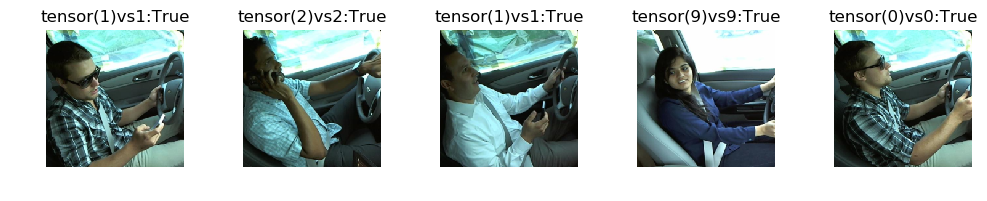

In [33]:
# preview sample of images
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5, 'src/val_m')

fig, ax =plt.subplots(1,5, figsize=(10,10))
ax = ax.flatten()

# compare true to predicted labels
# image title in format:
# tensor(<true class>)vs(<predicted class>):(<bool>)
for ii in range(len(images[0])):
    image = to_pil(images[0][ii,])
    index = predict_image(image)
    r = int(labels[0][ii]) == index
    ax[ii].set_title(str(labels[0][ii]) + 'vs' + str(index) + ":" + str(r))
    ax[ii].axis('off')
    
    ax[ii].imshow(image)

plt.tight_layout()
plt.show()

In [34]:
# get larger sample
np.random.seed(42)
images, labels = get_random_images(500, 'src/val_m')
res = []
for ii in range(len(images[0])):
    image = to_pil(images[0][ii,])
    index = predict_image(image)
    r = int(labels[0][ii]) == index
    res.append(index)

418


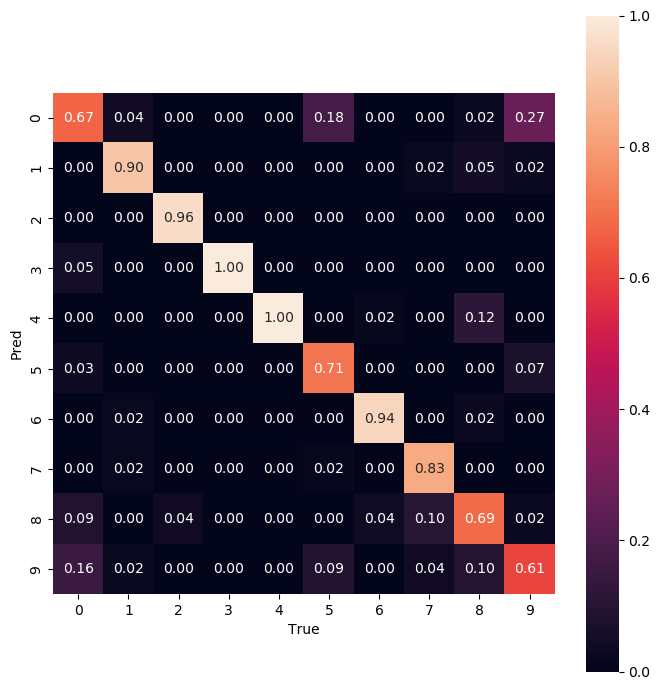

In [35]:
# create confusion matrix of sample
print(sum([1 if i == j else 0 for i,j in zip(res, labels[0])]))

_, counts = np.unique(np.array(res), return_counts=True)

conf = confusion_matrix(y_true=labels[0], y_pred=res)

_, ax = plt.subplots(1,1, figsize=(7,7))

sns.heatmap(conf/counts, annot=True, fmt='.2f', square=True, ax=ax)
plt.xlabel('True')
plt.ylabel('Pred')
plt.tight_layout();

In [22]:
#images = images[0]

In [35]:
def feature_importance(model, images, category):
    ##from exercises
    f1 = model.conv1(images)
    f2 = model.bn1(f1)
    f3 = model.relu(f2)
    f4 = model.maxpool(f3)
    f5 = model.layer1(f4)
    f6 = model.layer2(f5)
    f7 = model.layer3(f6)
    f8 = model.layer4(f7)

    f8.retain_grad()

    f9 = model.avgpool(f8).reshape(-1,512)
    out = model.fc(f9)

    torch.mean(out[:,category]).backward()

    pooled_feature_gradient = torch.mean(f8.grad, dim=[0, 2, 3])

    heatmap = F.relu(torch.mean(f8 * pooled_feature_gradient[:, None, None], dim=1))

    heatmap = heatmap / torch.amax(heatmap, dim=(1, 2))[:, None, None]
    return heatmap, pooled_feature_gradient, f8

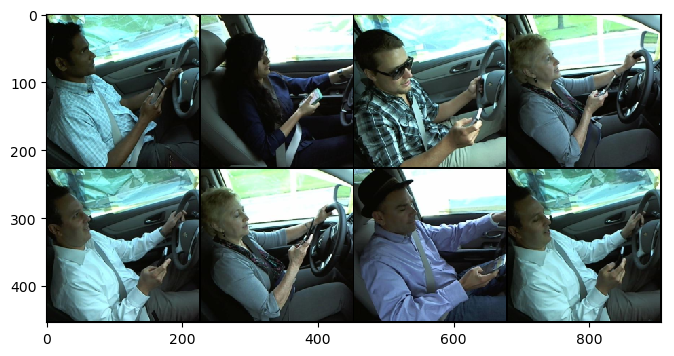

In [36]:
folder = './src/val_m/c1'

images = []
images_orig = []
for file in os.listdir(folder)[0:8]:
    if file.endswith('jpg'):

        img = Image.open(rf'{folder}/' + file)
        images.append(transform(img))
        images_orig.append(transform_no_normalize(img))

images = torch.stack(images).to(device)
# This command is important to move the images also to memory on GPU. Otherwise pytorch will complain.

fig = plt.figure(figsize=(16,4))
img_grid = make_grid(images_orig, nrow=4)
# this is a torchvision utility to put images together into a grid for plotting

plt.imshow(img_grid.detach().numpy().transpose(1,2,0))
# the transpose command above re-arranges the order of dimensions of a tensor.
# make_grid by default generates a tensor of channel x height x width.
# But matplotlib assumes that red, green and blue channels are in the last dimension of a tensor.
plt.show()

In [37]:
logit = model(images)
# By simply passing the image as input, the network

# the class with the highest logit will have the highest probability
pred_id = logit.argmax(dim=1) 
print('predicted category ID:', pred_id)

pred_class = [classes[class_id]  for class_id in pred_id.detach().cpu().numpy()]
print('network classification:', pred_class)

class_id = torch.mode(pred_id).values
print('ID of the class:', class_id)

predicted category ID: tensor([1, 1, 1, 1, 1, 1, 9, 1], device='cuda:0')
network classification: [1, 1, 1, 1, 1, 1, 9, 1]
ID of the class: tensor(1, device='cuda:0')


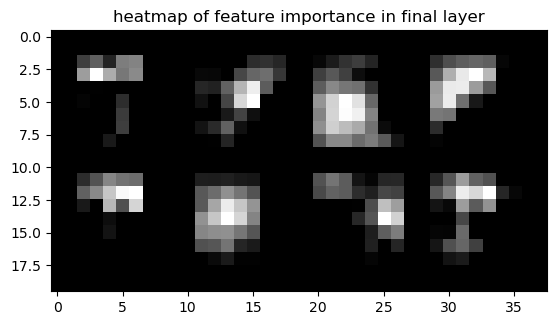

f:\Users\Christian\anaconda3\envs\aml4ds\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


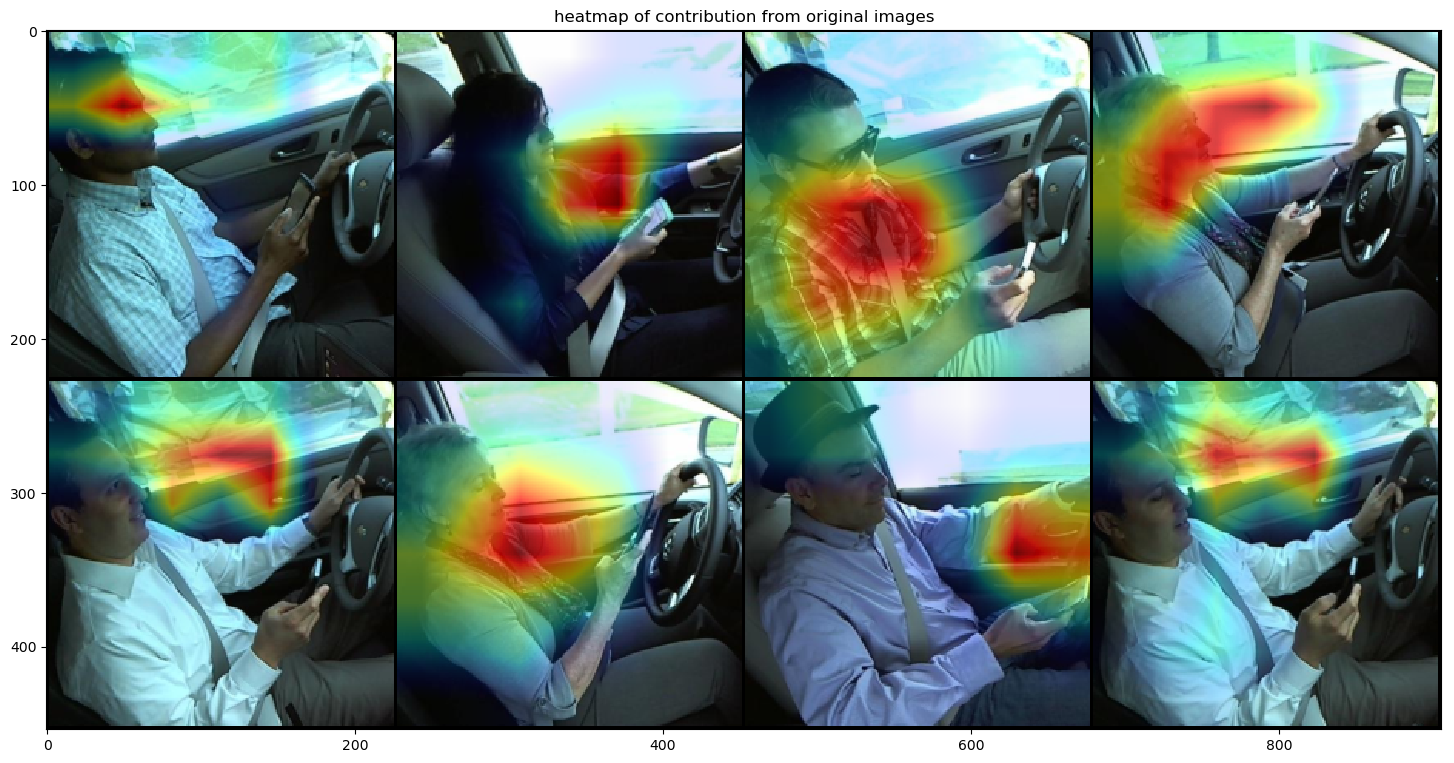

In [38]:
# @title ##### Now we analyze the layer right before the final pooling using the sample images. You can also try other layers
heatmap, pooled_feature_gradient, features = feature_importance(model, images, 0)
# Yatta! Now we can visualize both the contribution map in that layer, and blend the contribution map

hms = heatmap.detach().cpu()[:,None,:,:]

plt.imshow(make_grid(hms,nrow=4).numpy().transpose(1,2,0), cmap='jet')
plt.title('heatmap of feature importance in final layer')
plt.show()

cmap = cm.get_cmap('jet')
resized_heatmap = transforms.Resize(224)(heatmap.detach())
resized_heatmap_color = cmap(resized_heatmap.cpu().numpy())[:,:,:,:3].transpose(0, 3, 1, 2)

#plt.imshow(hms[0,0,:,:], cmap='jet', interpolation='nearest')
#plt.show()
#plt.imshow(resized_heatmap[0,:,:].cpu().detach().numpy(), cmap='jet', interpolation='nearest')
#plt.show()

weight = resized_heatmap[:,None,:,:].cpu().numpy() * 0.8
highlighted_images = torch.stack(images_orig) * (1 - weight) + resized_heatmap_color * weight
img_grid = make_grid(highlighted_images, nrow=4)
plt.figure(figsize=(18,12))
plt.imshow(img_grid.numpy().transpose(1,2,0))
plt.title('heatmap of contribution from original images')
plt.show()